<b>Data mining project - 2020/21</b><br>
<b>Authors</b>: [Alexandra Bradan](https://github.com/alexandrabradan), [Alice Graziani](https://github.com/alicegraziani25) and [Eleonora Cocciu](https://github.com/eleonoracocciu)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 21/05/2021<b>

In [109]:
# system library
import os
import sys
import json
import datetime
import calendar
from datetime import date, timedelta

# useful libraries
import math
import operator
import itertools
import statistics
import collections
from collections import Counter
from collections import OrderedDict

# pandas
import pandas as pd

# numpy
import numpy as np
from numpy import std
from numpy import mean
from numpy import percentile

# visualisarion
import pydotplus
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import Image

# sklearn
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

# dimensional reducers
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif  # classification
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression  # regression

# scalers
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder

# performance visualisation 
from sklearn import tree
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from sklearn.model_selection import learning_curve
from mlxtend.plotting import plot_decision_regions
from yellowbrick.model_selection import LearningCurve

# svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

plt.rcParams["patch.force_edgecolor"] = True
%matplotlib inline

from yellowbrick.style import set_palette
set_palette('bold')

<h6> Datasets loading </h6>

In [69]:
df = pd.read_csv('../../data/fma_metadata/group_20_fma.csv', index_col=0)
tracks = pd.read_csv('../../data/fma_metadata/tracks.csv', index_col=0, header=[0, 1])
print(df.shape)

(103708, 44)


<h6>Recompose track_date_created column</h6>

In [70]:
# TODO: remove dt.date if we will use hours, minutes and seconds
# .dt.normalize()
date_created_column = pd.to_datetime(tracks[('track', 'date_created')], format='%Y%m', errors='ignore').astype('datetime64[ns]')
track_date_created_year_index = df.columns.get_loc("track_date_created_year")
track_date_created_season_index = df.columns.get_loc("track_date_created_season")

In [71]:
df.insert(track_date_created_year_index, 'track_date_created', date_created_column)
del df["track_date_created_year"]
del df["track_date_created_season"]

<h2> Created Counter based uppon years, months, weeks, days and hours</h2>

Track creation spans between **2008-11-25 17:49:06** and **2017-03-30 15:23:39**, so we will differenciate between the following datetime divisions:

- 10 years;
- 101 months;
- 435 weeks;
- 3.048 days;
- 73.125 hours (73.126 approximated).

<b><font color="green">N.B. When analyzing months, days and hours remember to make considerations upon season, weekdays and moments of the day </font></b>

At least one track belonging to a Live or Studio Recoriding was created in all years and months, while increasing datetime's granualiry, we discover that:
- no Studio Recording tracks were created between 2008-12-22 and 2009-01-04, between 2012-01-02 and 2012-01-08,  2012-12-31 and 2013-01-06, 2013-12-30 and 2014-01-05, 2014-12-29 and 2015-01-04 with high probability due to Christmas or New Eves holidays; between 2014-03-31 and 2014-04-06 we have another pause, probably due to some mantaince problems. The same is valide for Live Recording tracks, with the difference that between 2008-12-22 and 2009-01-04 were created radio/live performance content;


In [72]:
def print_years_insight(external_df, track_date_created_sub_info, album_type_flag):
    curr_df = external_df.copy()
    if album_type_flag != "":
        curr_df = curr_df[curr_df["album_type"] == album_type_flag]
    
    count = 0
    print("year", track_date_created_sub_info, "count", sep="\t")
    for year in df["track_date_created"].dt.year.unique():
        if track_date_created_sub_info == "years":
            tmp = len(curr_df[curr_df["track_date_created"].dt.year == year]['track_date_created'].dt.year.unique())
        elif track_date_created_sub_info == "months":
            tmp = len(curr_df[curr_df["track_date_created"].dt.year == year]['track_date_created'].dt.month.unique())
        elif track_date_created_sub_info == "weeks":
            tmp = len(curr_df[curr_df["track_date_created"].dt.year == year]['track_date_created'].dt.week.unique())
        elif track_date_created_sub_info == "days":
            tmp = len(curr_df[curr_df["track_date_created"].dt.year == year]['track_date_created'].dt.day.unique())
        elif track_date_created_sub_info == "hours":
            tmp = len(curr_df[curr_df["track_date_created"].dt.year == year]['track_date_created'].dt.hour.unique())
        else:
            print("wrong track_date_created_sub_info=%s" % track_date_created_sub_info)
            sys.exit(-1)
        print(year, tmp, count, sep="\t")
        count += tmp
    print("final count", count)

In [73]:
def get_start_end_dates(year, week):
    d = datetime.date(year,1,1)
    if(d.weekday()<= 3):
        d = d - datetime.timedelta(d.weekday())             
    else:
        d = d + datetime.timedelta(7-d.weekday())
    dlt = datetime.timedelta(days = (week-1)*7)
    return d + dlt,  d + dlt + datetime.timedelta(days=6)

In [74]:
print_years_insight(df, "years", "")

year	years	count
2008	1	0
2009	1	1
2010	1	2
2011	1	3
2012	1	4
2013	1	5
2014	1	6
2015	1	7
2016	1	8
2017	1	9
final count 10


In [75]:
print_years_insight(df, "months", "")

year	months	count
2008	2	0
2009	12	2
2010	12	14
2011	12	26
2012	12	38
2013	12	50
2014	12	62
2015	12	74
2016	12	86
2017	3	98
final count 101


In [76]:
print_years_insight(df, "weeks", "")

year	weeks	count
2008	6	0
2009	53	6
2010	53	59
2011	52	112
2012	52	164
2013	52	216
2014	51	268
2015	53	319
2016	53	372
2017	14	425
final count 439


In [77]:
print_years_insight(df, "weeks", "Studio Recording")

year	weeks	count
2008	4	0
2009	53	4
2010	53	57
2011	52	110
2012	52	162
2013	52	214
2014	51	266
2015	53	317
2016	53	370
2017	14	423
final count 437


In [151]:
def translate_x(x, remapping_dict):
    keys = list(remapping_dict.keys())
    values = list(remapping_dict.values())

    x_translated = []
    for plot_index in x:
        key_index = values.index(plot_index)
        translation = keys[key_index]
        x_translated.append(translation)
    return x_translated

In [78]:
def studio_and_live_recording_years_timeframe(external_df):
    curr_df = external_df.copy()
    gouped_factor = curr_df.track_date_created.dt.year
    grouped_df = curr_df.groupby([gouped_factor, curr_df.album_type]).agg('count')['track_date_created'].to_frame()
    grouped_df = grouped_df.rename_axis(["lvl0", "lvl1"])
    df1 = grouped_df.query("lvl1 != 'Live Recording'")  # Studio Recording
    df2 = grouped_df.query("lvl1 != 'Studio Recording'")  # Live Recording
    y1 = df1['track_date_created']
    y2 = df2['track_date_created']
    x = pd.unique(external_df.track_date_created.dt.year)

    return x, y1, y2

In [584]:
def studio_and_live_recording_months_timeframe(external_df):
    start = external_df['track_date_created'].min()
    end = external_df['track_date_created'].max()
    num_months = (end.year - start.year) * 12 + (end.month - start.month)
    # print('months between start and end:', num_months + 2) # counting start and end months

    start_month = pd.Timestamp(start.year, start.month, 1)
    end_month = pd.Timestamp(end.year, end.month, 1)
    if end_month <= end:  # check if we omitted end
        end_month = pd.Timestamp(end.year, end.month + 1, 1)

    # encode yearly months as contigous integers 
    i = 0
    weeks_remapping_dict = {}
    while(start_month <= end_month):
        weeks_remapping_dict[start_month.year, start_month.month] = i 
        i += 1
        start_month = start_month + relativedelta(months=+1)  # updating month
    
    # Studio and Live recording frequency counting based uppon months
    x = list(weeks_remapping_dict.values())
    y1 = [0]*(len(weeks_remapping_dict))
    y2 = [0]*(len(weeks_remapping_dict))
    for row in external_df[["track_date_created", "album_type"]].itertuples():
        d = row.track_date_created
        a = row.album_type        

        index = weeks_remapping_dict[d.year, d.month] 

        if a == "Studio Recording":
            y1[index] += 1
        elif a == "Live Recording":
            y2[index] += 1

    return x, weeks_remapping_dict, y1, y2

In [104]:
def get_season_from_month(month):
    if month == 3 or month == 4 or month == 5:
        return "Spring"
    if month == 6 or month == 7 or month == 8:
        return "Summer"
    if month == 9 or month == 10 or month == 11:
        return "Autumn"
    if month == 12 or month == 1 or month == 2:
        return "Winter"
    print("Wrong month=%s" % month)
    sys.exit(-1)

In [105]:
def studio_and_live_recording_seasons_timeframe(external_df):
    _, tmp_weeks_remapping_dict, _, _ = studio_and_live_recording_months_timeframe(external_df)
    
    # encode yearly seasons as contigous integers 
    i = 0
    elem_list = set()
    weeks_remapping_dict = {}
    for year, month in tmp_weeks_remapping_dict.keys():
        season = get_season_from_month(month)
        key = year, season
        if key not in elem_list:
            weeks_remapping_dict[key] = i
            elem_list.add(key)
            i += 1
        
    # Studio and Live recording frequency counting based uppon seasons
    x = list(weeks_remapping_dict.values())
    y1 = [0]*(len(x))
    y2 = [0]*(len(x))
    
    for row in external_df[["track_date_created", "album_type"]].itertuples():
        d = row.track_date_created
        a = row.album_type  
        d_season = get_season_from_month(d.month)

        index = weeks_remapping_dict[d.year, d_season] 
        
        if a == "Studio Recording":
            y1[index] += 1
        elif a == "Live Recording":
            y2[index] += 1

    return x, weeks_remapping_dict, y1, y2

In [585]:
def studio_and_live_recording_weeks_timeframe(external_df):
    start = external_df['track_date_created'].min()
    end = external_df['track_date_created'].max()
    monday1 = (start - timedelta(days=start.weekday())).date()
    monday2 = (end - timedelta(days=end.weekday())).date()
    # print('weeks between start and end:', round((monday2 - monday1).days / 7)) 

    # encode yearly weeks as contigous integers 
    i = 0
    weeks_remapping_dict = {}
    while(monday1 <= monday2):
        weeks_remapping_dict[monday1] = i 
        i += 1
        monday1 += timedelta(days=7)  # updating week
    # adding last week
    weeks_remapping_dict[monday1] = i

    # Studio and Live recording frequency counting based uppon year's weeks 
    x = list(weeks_remapping_dict.values())
    y1 = [0]*(len(weeks_remapping_dict))
    y2 = [0]*(len(weeks_remapping_dict))
    for row in external_df[["track_date_created", "album_type"]].itertuples():
        d = row.track_date_created
        a = row.album_type        
        d_monday = (d - timedelta(days=d.weekday())).date()  # retrieve week's monday

        index = weeks_remapping_dict[d_monday] 

        if a == "Studio Recording":
            y1[index] += 1
        elif a == "Live Recording":
            y2[index] += 1

    return x, weeks_remapping_dict, y1, y2

In [586]:
def studio_and_live_recording_days_timeframe(external_df):

    start = external_df['track_date_created'].min()
    end = external_df['track_date_created'].max()
    delta = end - start
    # print('days between start and end:', delta.days + 2)  

    # encode yearly days as contigous integers 
    days_remapping_dict = {}
    for i in range(0, delta.days + 2):  # adding 2 extra days to contemplate end
        day = start + timedelta(days=i)
        key = day.year, day.month, day.day
        days_remapping_dict[key] = i 

    # Studio and Live recording frequency counting based uppon year's and month's day 
    x = list(days_remapping_dict.values())
    y1 = [0]*(len(days_remapping_dict))
    y2 = [0]*(len(days_remapping_dict))
    for row in external_df[["track_date_created", "album_type"]].itertuples():
        d = row.track_date_created
        a = row.album_type
        key = d.year, d.month, d.day

        index = days_remapping_dict[key] 

        if a == "Studio Recording":
            y1[index] += 1
        elif a == "Live Recording":
            y2[index] += 1
            
    return x, days_remapping_dict, y1, y2

In [249]:
def get_weekday_from_day(year, month, day):
    my_date = datetime.date(year, month, day)
    week_day =  calendar.day_name[my_date.weekday()]
    
    if week_day == "Saturday" or week_day == "Sunday":
        return "Weekend"
    else:
        return "Workday"

In [250]:
def studio_and_live_recording_weekdays_timeframe(external_df):
    _, tmp_days_remapping_dict, _, _ = studio_and_live_recording_days_timeframe(external_df)
    
    # encode yearly weekdays as contigous integers 
    i = 0
    elem_list = set()
    days_remapping_dict = {}
    for year, month, day in tmp_days_remapping_dict.keys():
        weekday = get_weekday_from_day(year, month, day)
        key = year, month, weekday
        if key not in elem_list:
            days_remapping_dict[key] = i
            elem_list.add(key)
            i += 1

    # Studio and Live recording frequency counting based uppon year's and month's day 
    x = list(days_remapping_dict.values())
    y1 = [0]*(len(days_remapping_dict))
    y2 = [0]*(len(days_remapping_dict))
    for row in external_df[["track_date_created", "album_type"]].itertuples():
        d = row.track_date_created
        a = row.album_type
        weekday = get_weekday_from_day(d.year, d.month, d.day)
        key = d.year, d.month, weekday

        index = days_remapping_dict[key] 

        if a == "Studio Recording":
            y1[index] += 1
        elif a == "Live Recording":
            y2[index] += 1
            
    return x, days_remapping_dict, y1, y2

In [587]:
def studio_and_live_recording_hours_timeframe(external_df):
    start = external_df['track_date_created'].min()
    end = external_df['track_date_created'].max()
    delta = end - start

    days = []
    for i in range(0, delta.days + 2):
        day = start + timedelta(days=i)
        key = (day.year, day.month, day.day)
        days.append(key)

    ddays, seconds = delta.days, delta.seconds
    hours = ddays * 24 + seconds // 3600
    # print('hours between start and end:', hours)  
   
    # encode yearly hours as contigous integers 
    i = 0
    hours_remapping_dict = {}
    for d in days:
        for h in range(0, 24):
            key = d[0], d[1], d[2], h
            hours_remapping_dict[key] = i
            i += 1
          
    # Studio and Live recording frequency counting based uppon year's and day's hours
    x = list(hours_remapping_dict.values())
    y1 = [0]*(len(hours_remapping_dict))
    y2 = [0]*(len(hours_remapping_dict))
    
    for row in external_df[["track_date_created", "album_type"]].itertuples():
        d = row.track_date_created
        a = row.album_type
        key = d.year, d.month, d.day, d.hour

        index = hours_remapping_dict[key] 
        
        if a == "Studio Recording":
            y1[index] += 1
        elif a == "Live Recording":
            y2[index] += 1
        
    return x, hours_remapping_dict, y1, y2

In [229]:
def get_daymoment_from_hour(hour):
    if (hour >= 19 and hour <= 23) or (hour >= 0 and hour < 7):
        return "Night"
    if (hour >= 7 and hour < 19):
        return "Day"
    print("Wrong hour=%s" % hour)

In [245]:
def studio_and_live_recording_daymoments_timeframe(external_df):
    _, tmp_hours_remapping_dict, _, _ = studio_and_live_recording_hours_timeframe(external_df)
    
    # encode yearly daymoments as contigous integers 
    i = 0
    elem_list = set()
    hours_remapping_dict = {}
    for year, month, day, hour in tmp_hours_remapping_dict.keys():
        daymoment = get_daymoment_from_hour(hour)
        key = year, month, daymoment
        if key not in elem_list:
            hours_remapping_dict[key] = i
            elem_list.add(key)
            i += 1
          
    # Studio and Live recording frequency counting based uppon year's and day's hours
    x = list(hours_remapping_dict.values())
    y1 = [0]*(len(hours_remapping_dict))
    y2 = [0]*(len(hours_remapping_dict))
    
    for row in external_df[["track_date_created", "album_type"]].itertuples():
        d = row.track_date_created
        a = row.album_type
        d_daymoment = get_daymoment_from_hour(d.hour)
        key = d.year, d.month, d_daymoment

        index = hours_remapping_dict[key] 
        
        if a == "Studio Recording":
            y1[index] += 1
        elif a == "Live Recording":
            y2[index] += 1
        
    return x, hours_remapping_dict, y1, y2

In [85]:
def plot_TS_based_uppon_album_type(external_df, target_flag, track_date_created_sub_info, log_flag):
    
    if track_date_created_sub_info == "years":
        x, y1, y2 = studio_and_live_recording_years_timeframe(external_df)
    elif track_date_created_sub_info == "months":
        x, x_map, y1, y2 = studio_and_live_recording_months_timeframe(external_df)
    elif track_date_created_sub_info == "weeks":
        x, x_map, y1, y2 =  studio_and_live_recording_weeks_timeframe(external_df)
    elif track_date_created_sub_info == "days":
        x, x_map, y1, y2 =  studio_and_live_recording_days_timeframe(external_df)
    elif track_date_created_sub_info == "hours":
        x, x_map, y1, y2 = studio_and_live_recording_hours_timeframe(external_df)
    elif track_date_created_sub_info == "seasons":
        x, x_map, y1, y2 = studio_and_live_recording_seasons_timeframe(external_df)
    elif track_date_created_sub_info == "weekdays":
        x, x_map, y1, y2 = studio_and_live_recording_weekdays_timeframe(external_df)
    elif track_date_created_sub_info == "daymoments":
        x, x_map, y1, y2 = studio_and_live_recording_daymoments_timeframe(external_df)
    else:
        print("wrong track_date_created_sub_info=%s" % track_date_created_sub_info)
        sys.exit(-1)

    fig, ax = plt.subplots(figsize=(8, 5))
    if target_flag == "":
        sns.lineplot(x=x, y=y1, label="Studio Recoridng")
        sns.lineplot(x=x, y=y2, label="Live Recoridng")
    elif target_flag == "Studio Recording":
        sns.lineplot(x=x, y=y1, label="Studio Recoridng")
    elif target_flag == "Live Recording":
        sns.lineplot(x=x, y=y2, label="Live Recoridng", color="mediumseagreen")
    
    if track_date_created_sub_info == "years":
        plt.xticks(x)
    if log_flag:
        plt.yscale("log")
    plt.xlabel(track_date_created_sub_info)
    plt.ylabel("count")
    plt.legend(title="album_type", loc="best")
    plt.title("Album type's frequency per %s" % track_date_created_sub_info)
    plt.show()

<h6>Years insight</h6>

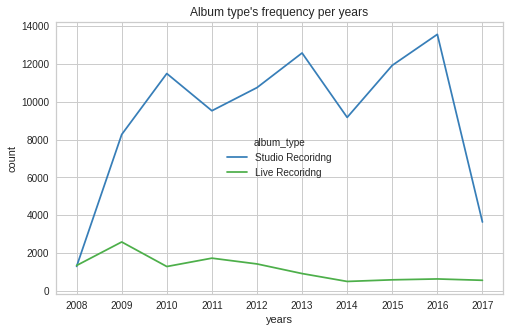

In [86]:
plot_TS_based_uppon_album_type(df, "", "years", False)

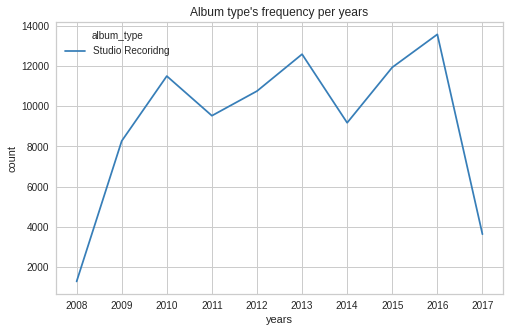

In [87]:
plot_TS_based_uppon_album_type(df, "Studio Recording", "years", False)

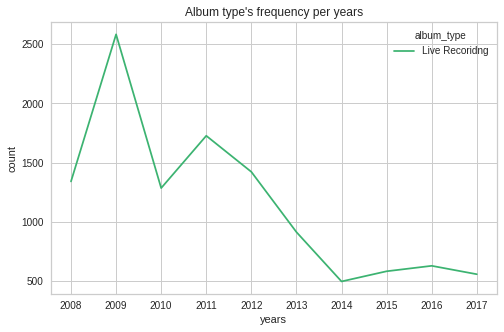

In [88]:
plot_TS_based_uppon_album_type(df, "Live Recording", "years", False)

<h6> Months insight </h6>

months between start and end: 102


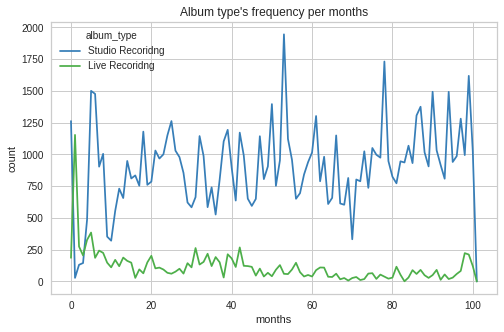

In [89]:
plot_TS_based_uppon_album_type(df, "", "months", False)

months between start and end: 102


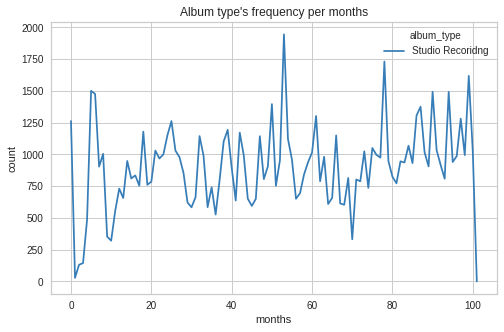

In [90]:
plot_TS_based_uppon_album_type(df, "Studio Recording", "months", False)

months between start and end: 102


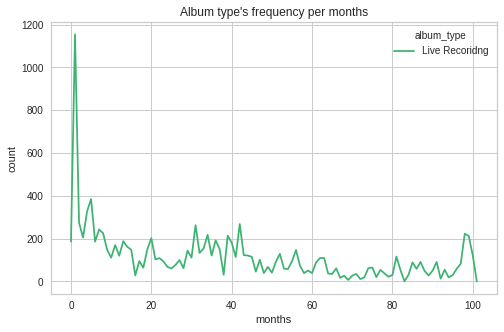

In [91]:
plot_TS_based_uppon_album_type(df, "Live Recording", "months", False)

<h6> Weeks insight </h6> 

weeks between start and end: 435


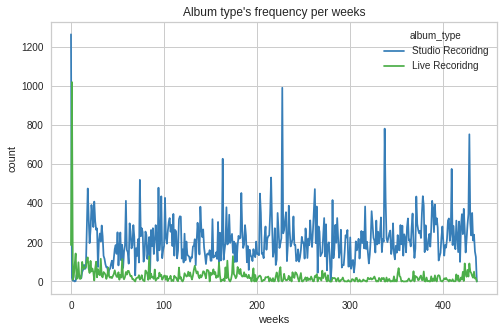

In [92]:
plot_TS_based_uppon_album_type(df, "", "weeks", False)

weeks between start and end: 435


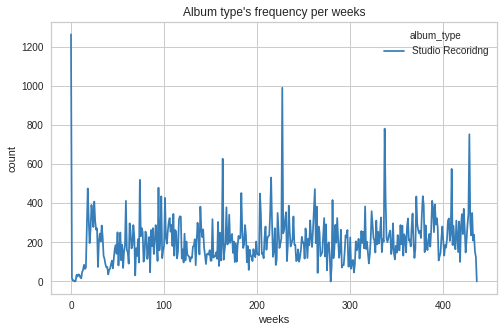

In [93]:
plot_TS_based_uppon_album_type(df, "Studio Recording", "weeks", False)

weeks between start and end: 435


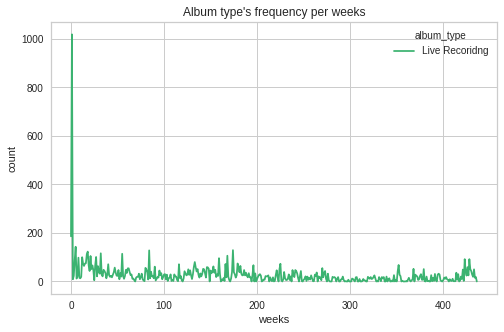

In [94]:
plot_TS_based_uppon_album_type(df, "Live Recording", "weeks", False)

<h6> Days insight </h6>

<b><font color="red"> Preferable to use Workday and Weekend yearly, monthly sliding window </font></b>

days between start and end: 3048


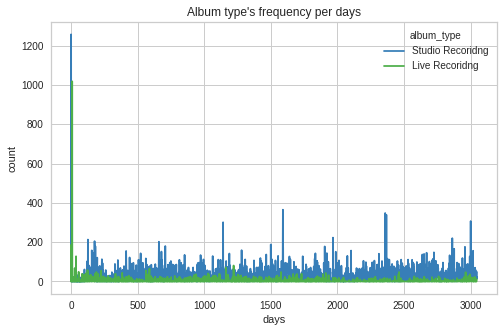

In [95]:
plot_TS_based_uppon_album_type(df, "", "days", False)

days between start and end: 3048


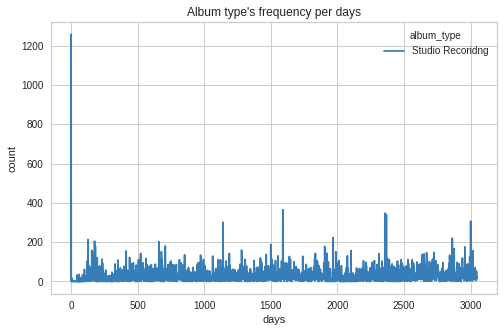

In [96]:
plot_TS_based_uppon_album_type(df, "Studio Recording", "days", False)

days between start and end: 3048


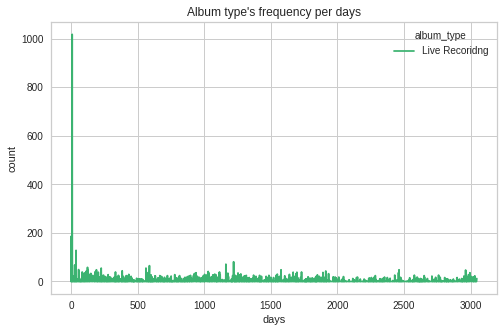

In [97]:
plot_TS_based_uppon_album_type(df, "Live Recording", "days", False)

<h6>Hours insight </h6>

<b><font color="red"> Preferable to use Day and Night yearly, monthly sliding window </font></b>

days between start and end: 73125


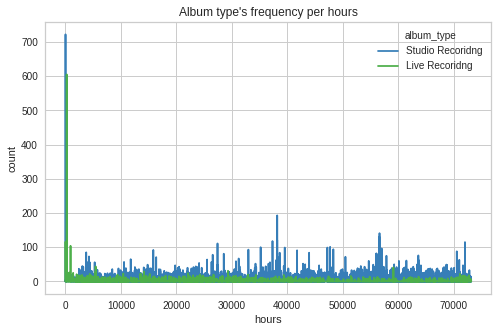

In [98]:
plot_TS_based_uppon_album_type(df, "", "hours", False)

days between start and end: 73125


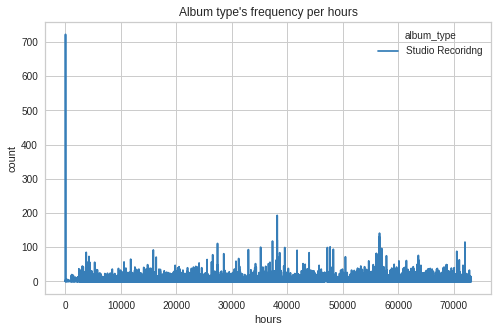

In [99]:
plot_TS_based_uppon_album_type(df, "Studio Recording", "hours", False)

days between start and end: 73125


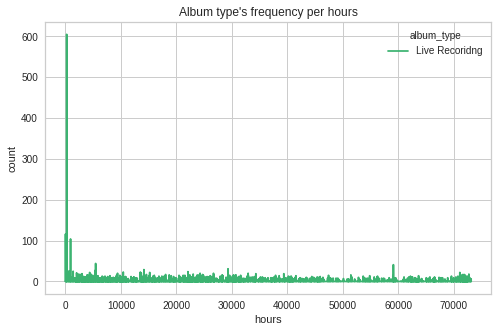

In [100]:
plot_TS_based_uppon_album_type(df, "Live Recording", "hours", False)

<h6>Season insight </h6>

months between start and end: 102


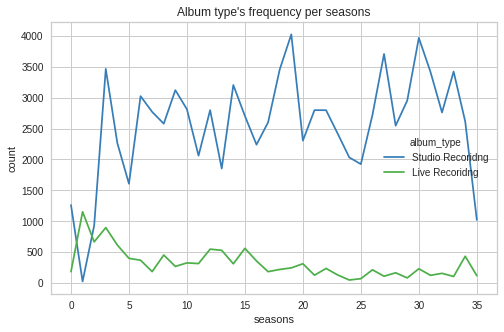

In [101]:
plot_TS_based_uppon_album_type(df, "", "seasons", False)

months between start and end: 102


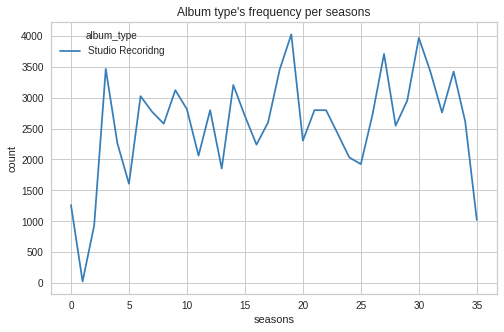

In [102]:
plot_TS_based_uppon_album_type(df, "Studio Recording", "seasons", False)

months between start and end: 102


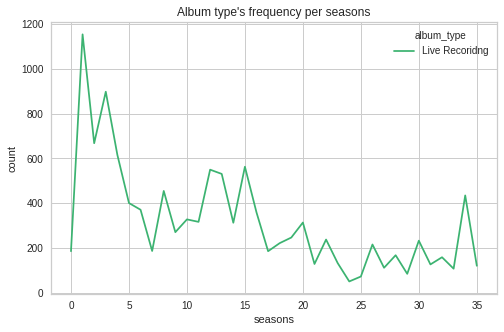

In [103]:
plot_TS_based_uppon_album_type(df, "Live Recording", "seasons", False)

<h6>Weekdays insight </h6>

days between start and end: 3048


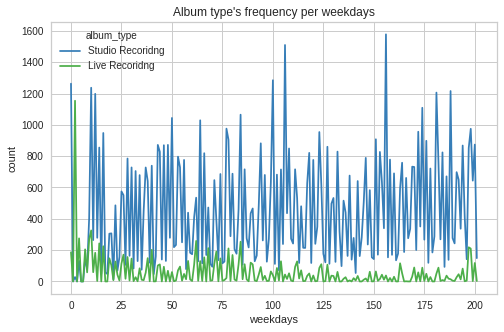

In [252]:
plot_TS_based_uppon_album_type(df, "", "weekdays", False)

days between start and end: 3048


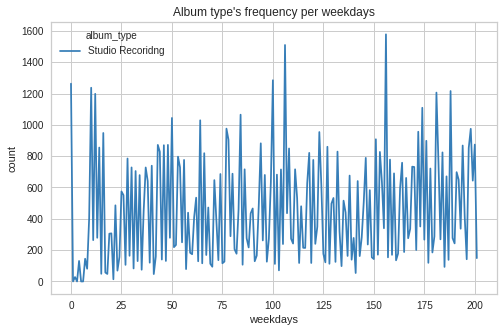

In [253]:
plot_TS_based_uppon_album_type(df, "Studio Recording", "weekdays", False)

days between start and end: 3048


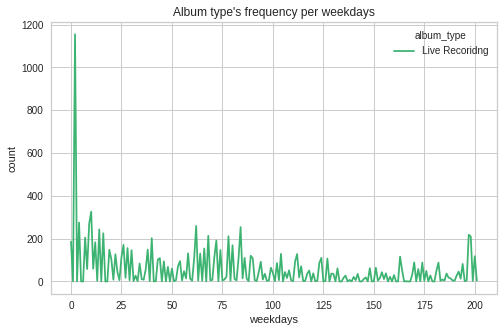

In [251]:
plot_TS_based_uppon_album_type(df, "Live Recording", "weekdays", False)

<h6> Daymoments insight </h6>

hours between start and end: 73125


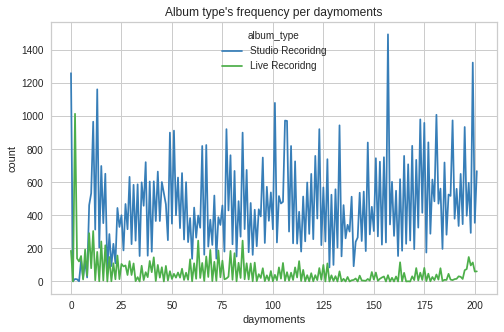

In [247]:
plot_TS_based_uppon_album_type(df, "", "daymoments", False)

hours between start and end: 73125


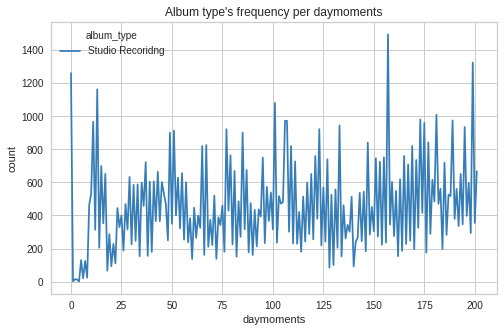

In [254]:
plot_TS_based_uppon_album_type(df, "Studio Recording", "daymoments", False)

hours between start and end: 73125


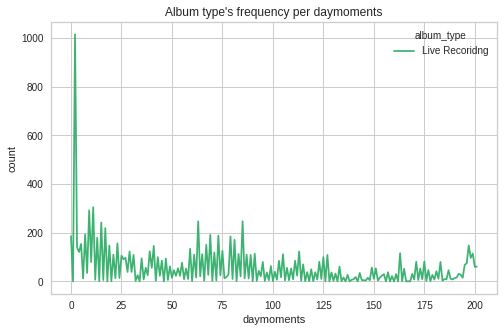

In [246]:
plot_TS_based_uppon_album_type(df, "Live Recording", "daymoments", False)

<h2>Build DataFrames from TS</h2>

In [511]:
def get_yearly_data(external_df, x, y1, y2):
        data = {'track_date_created_year': years}
        data2 = {}
        data['Studio_Recording_year_freq'] =  y1
        data2['Live_Recording_year_freq'] =  y2
        # merge dicts
        data.update(data2)
        return data

In [538]:
def get_extended_names(names):
    extended_names = []
    for i in range(0, 12):
        extended_names.append(names[0])
        extended_names.append(names[1])

    j = 1
    for i in range(1, len(extended_names) + 1, 2):
        extended_names[i-1] = str(extended_names[i-1]) + "_" + str(j)
        extended_names[i] = str(extended_names[i]) + "_" + str(j)
        j += 1
    return extended_names

In [634]:
def get_data(names, track_date_created_sub_info, external_df, x, y1, y2):
    
    if track_date_created_sub_info == "years":
        return get_yearly_data(external_df, x, y1, y2)
    
    if track_date_created_sub_info in ["weekdays", "daymoments"]:
        names = get_extended_names(names)
    
    start = external_df['track_date_created'].min()
    end = external_df['track_date_created'].max() 
    years = sorted(list(external_df['track_date_created'].dt.year.unique()))
    
    data = {'track_date_created_year': years}
    data2 = {}
    min_univocal_values = 1
    univocal_values = len(names)
    rows = [[0]*univocal_values for _ in range(0, len(years))]
    rows2 = [[0]*univocal_values for _ in range(0, len(years))]

    for ex, ey1, ey2 in zip(x, y1, y2):
        if track_date_created_sub_info == "seasons":
            internal_row_index = names.index(ex[1])
        elif track_date_created_sub_info in ["weekdays", "daymoments"]:
            key = str(ex[2]) + "_" + str(ex[1])
            internal_row_index = names.index(key)
        elif track_date_created_sub_info == "weeks":
            internal_row_index = week_number = ex.isocalendar()[1] - 1 # year's week number (starts from 1)
            if internal_row_index == 52:  # shift to next year
                year_row_index += 1
                internal_row_index = 0
        elif track_date_created_sub_info == "months":
            internal_row_index = int(ex[1]) - min_univocal_values
        
        if track_date_created_sub_info == "weeks":
            year_row_index = int(ex.year) - int(start.year)
            rows[year_row_index][internal_row_index] += ey1  # contemplate shift
            rows2[year_row_index][internal_row_index] += ey2  # contemplate shift
        else:
            year_row_index = int(ex[0]) - int(start.year)
            rows[year_row_index][internal_row_index] = ey1
            rows2[year_row_index][internal_row_index] = ey2

    columns = [[0]*len(years) for _ in range(0, univocal_values)]
    columns2 = [[0]*len(years) for _ in range(0, univocal_values)]

    for j in range(0, univocal_values):
        for i in range(0, len(years)):
            columns[j][i] = rows[i][j]
            columns2[j][i] = rows2[i][j]

    key1 = 'Studio_Recording_' + track_date_created_sub_info.replace("s", "") + '_'
    for j in range(0, univocal_values):
        tmp_key = key1 + str(names[j]).lower()
        data[tmp_key] = columns[j]

    key2 = 'Live_Recording_'  + track_date_created_sub_info.replace("s", "") + '_'
    for j in range(0, univocal_values):
        tmp_key = key2 + str(names[j]).lower()
        data2[tmp_key] = columns2[j]
        
    # merge dicts
    data.update(data2)
    
    return data

In [635]:
def build_TS_dataframe(external_df, track_date_created_sub_info):
    
    years = sorted(list(external_df['track_date_created'].dt.year.unique()))
    if track_date_created_sub_info == "years":
        x, y1, y2 = studio_and_live_recording_years_timeframe(df)
    elif track_date_created_sub_info == "months":
        x, x_map, y1, y2 = studio_and_live_recording_months_timeframe(df)
    elif track_date_created_sub_info == "weeks":
        x, x_map, y1, y2 =  studio_and_live_recording_weeks_timeframe(df)
    elif track_date_created_sub_info == "days":
        pass
    elif track_date_created_sub_info == "hours":
        pass
    elif track_date_created_sub_info == "seasons":
        x, x_map, y1, y2 = studio_and_live_recording_seasons_timeframe(df)
    elif track_date_created_sub_info == "weekdays":
        x, x_map, y1, y2 = studio_and_live_recording_weekdays_timeframe(df)
    elif track_date_created_sub_info == "daymoments":
        x, x_map, y1, y2 = studio_and_live_recording_daymoments_timeframe(df)
        
    if track_date_created_sub_info != "years":
        x = translate_x(x, x_map)
    else:
        x = list(x)
        y1 = list(y1.values)
        y2 = list(y2.values)
        
    if track_date_created_sub_info == "years":
        names = list(range(2008, 2018))
    elif track_date_created_sub_info == "months":
        names = list(range(1, 13))
    elif track_date_created_sub_info == "weeks":
        names = list(range(1, 53))
    elif track_date_created_sub_info == "seasons":
        names = ["Spring", "Summer", "Autumn", "Winter"]
    elif track_date_created_sub_info == "weekdays":
        names = ["Workday", "Weekend"]
    elif track_date_created_sub_info == "daymoments":
        names = ["Day", "Night"]
    data = get_data(names, track_date_created_sub_info, external_df, x, y1, y2)
    
    # create DataFrame with 'track_date_created_year' column as index
    df_ts = pd.DataFrame(data=data)
    df_ts = df_ts.set_index('track_date_created_year')
    
    return df_ts

In [636]:
TSs = ["years", "months", "weeks", "seasons", "weekdays", "daymoments"]  # N.B. omitting "days" and "hours"

for track_date_created_sub_info in TSs:
    # print(track_date_created_sub_info)
    df_ts = build_TS_dataframe(df, track_date_created_sub_info)
    # save DataFrame on file
    filename = track_date_created_sub_info + "_freq.csv"
    df_ts.to_csv('../../data/fma_metadata/' + filename, index=True, header=True)